# Causal Machine Learning for Treatment Effect Estimation

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR

from significance import *

import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition, multicol
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [2]:
#!pip show scikit-learn

In [3]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of minor social activities, more than 30 days ago. 
EXPOSURE_THRESHOLD = 1  # SET TO 30 #30 = 1

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 120 # /MAYBE CHECK WITH 60? 
PERIOD_MAX = 240 # CHECK WITH 120 DAYS 

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = True

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.8

# set to True if we want to undersample
UNDERSAMPLE = False #False #True

# set to True if we want to impute missing values
IMPUTE =  True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True

TREATMENT = 'is2i' # (days of Social activities)
OUTCOME = 'sCPS' 

In [4]:
#df

Having set the desired parameters, we will now read in the data.

In [5]:
file = "data/dutch_LTCF_all.csv"

# read data
df = pd.read_csv(file)
print(f"Treatment before processing {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

Treatment before processing 25693


In [6]:
df['Facility_country'].fillna('unknown').value_counts()
print(df['Facility_country'].fillna('unknown').value_counts())

1.0        29199
unknown    15838
2.0         3105
Name: Facility_country, dtype: int64


In [7]:
df_netherlands= df[(df['Facility_country'] ==1)|(df['Facility_country'].isna())]
print(df_netherlands)

       Unnamed: 0    Clientid  Snapshotid  qrt  qrt2  Clientid_original  \
0               1          42         NaN    1     1                NaN   
1               2          43         NaN    1     1                NaN   
2               3          82         NaN    2     1                NaN   
3               4          82         NaN    1     2                NaN   
4               5          83         NaN    1     1                NaN   
...           ...         ...         ...  ...   ...                ...   
48137       48138  1825793914      6087.0    1     1             6086.0   
48138       48139  3998986670     13331.0    1     1            13330.0   
48139       48140  6135579548     20453.0    1     1            20452.0   
48140       48141  8479471735     28266.0    1     1            28265.0   
48141       48142  2789090703     30429.0    7     1             9297.0   

       ClientDepartmentcode  facility_id_first  facility_id  Facility_country  \
0                 

In [8]:
df['Facility_country'].value_counts()
print(df['Facility_country'].value_counts())

1.0    29199
2.0     3105
Name: Facility_country, dtype: int64


In [9]:
print(df['Facility_country'].unique())

[ 1.  2. nan]


In [10]:
unique_countries=df["Facility_country"].unique()
print(unique_countries)

[ 1.  2. nan]


In [11]:
df=df_netherlands

In [12]:
df['Facility_country'].fillna('unknown').value_counts()
print(df['Facility_country'].fillna('unknown').value_counts())

1.0        29199
unknown    15838
Name: Facility_country, dtype: int64


In [13]:
df["Facility_country"].value_counts(dropna=False).sort_index()

1.0    29199
NaN    15838
Name: Facility_country, dtype: int64

In [14]:
frequency_table =df['ia8'].value_counts(dropna=False).sort_index()
print(frequency_table)

0.0        7
1.0     8520
2.0    29358
3.0     1152
4.0      269
5.0      118
6.0     4921
7.0      237
NaN      455
Name: ia8, dtype: int64


In [15]:
frequency_table =df['ia8'].value_counts(dropna=False).sort_index()
print(frequency_table)

0.0        7
1.0     8520
2.0    29358
3.0     1152
4.0      269
5.0      118
6.0     4921
7.0      237
NaN      455
Name: ia8, dtype: int64


In [16]:
#df.to_excel("excel_version1.xlsx")

In [17]:
#example how to created new variable is2i.cat from is2i
# new variable is2i.cat will take values 1 (if is2i=1 or 3 or 4) or 0 (if is2i=0 or is2i=2)
df['is2i.cat']=df['is2i'].apply(lambda x: 0 if(x==0 or x==2) else 1 if (x==1 or x==3 or x==4) else None)
# Control
pd.crosstab(df['is2i'],df['is2i.cat'])

is2i.cat,0.0,1.0
is2i,,
0.0,16461,0
1.0,0,1807
2.0,3499,0
3.0,0,6814
4.0,0,12133


In [18]:
#example how to created new variable ia4.cat from ia4
#ia4= marital status
# 1= never married, 2= married, 3= partner/significant other, 4= widowed, 5= seperated,6= divorced
# new variable ia4.cat will take values 1 (if ia4=2 or 3) or 0 (if ia4= 1 or 4 or 5 or 6)
df['ia4.cat']=df['ia4'].apply(lambda x: 1 if(x==2 or x==3) else 0 if (x==1 or x==4 or x==5 or x==6) else None)
# Control
pd.crosstab(df['ia4'],df['ia4.cat'])

ia4.cat,0.0,1.0
ia4,,
1.0,5026,0
2.0,0,8661
3.0,0,293
4.0,20366,0
5.0,57,0
6.0,1967,0


In [19]:
#example how to created new variable id3a.cat from id3a
#id3a= Hearing ability
# 0= adequate, 1= minimal difficulty, 2= moderate difficulty, 3= severe difficulty, 4= no hearing
# new variable id3a.cat will take values 1 (if id3a=1 or 2 or 3 or 4) or 0 (if id3a=0)
#df['id3a.cat']=df['id3a'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4) else None)
# Control
#pd.crosstab(df['id3a'],df['id3a.cat'])

In [20]:
#example how to created new variable id4a.cat from id4a
#id4a= Hearing ability
# 0= adequate, 1= minimal difficulty, 2= moderate difficulty, 3= severe difficulty, 4= no hearing
# new variable id4a.cat will take values 1 (if id4a=1 or 2 or 3 or 4) or 0 (if id4a=0)
#df['id4a.cat']=df['id4a'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4) else None)
# Control
#pd.crosstab(df['id4a'],df['id4a.cat'])

In [21]:
#example how to create a new variable ij5a.cat from ij5a
#ij5a= pain frquency
# 0= no pain, 1= presesnt but not exhibited in last 3 days, 2= exhibited on 1-2 of last 3 days,3= exhibited daily in last 3 days
# new variable ij5a.cat will take values 1 (if ij5a=1 or 2 or 3 ) or 0 (if iij5a=0)
#df['ij5a.cat']=df['ij5a'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 ) else None)
# Control
#pd.crosstab(df['ij5a'],df['ij5a.cat'])

In [22]:
#example how to create a new variable ij5b.cat from ij5b
#ij5b= pain intensity
# 0= no pain, 1= mild, 2= moderates,3= severe, 4= times when pain is horrible 
# new variable ij5b.cat will take values 1 (if ij5b=1 or 2 or 3 or 4) or 0 (if ij5b=0)
#df['ij5b.cat']=df['ij5b'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4) else None)
# Control
#pd.crosstab(df['ij5b'],df['ij5b.cat'])

In [23]:
#example how to create a new variable for ADLs ig2b.cat from ig2b
#ig2b= personal hygiene
# 0= independent, 1= independent, set up only, 2= supervision,3= limited assistance, 4= extensive assistance, 5= maximal assistance, 6= total dependence, 8= activity did not occure
# new variable ig2b.cat will take values 1 (if ig2b=1 or 2 or 3 or 4 or 5 or 6 or 8) or 0 (if ig2b=0)
#df['ig2b.cat']=df['ig2b'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4 or x==5 or x==6 or x==8) else None)
# Control
#pd.crosstab(df['ig2b'],df['ig2b.cat'])

In [24]:
#example how to create a new variable for ADLs ig2f.cat from ig2f
#ig2f= toilet use
# 0= independent, 1= independent, set up only, 2= supervision,3= limited assistance, 4= extensive assistance, 5= maximal assistance, 6= total dependence, 8= activity did not occure
# new variable ig2f.cat will take values 1 (if ig2f=1 or 2 or 3 or 4 or 5 or 6 or 8) or 0 (if ig2f=0)
#df['ig2f.cat']=df['ig2f'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4 or x==5 or x==6 or x==8) else None)
# Control
#pd.crosstab(df['ig2f'],df['ig2f.cat'])

In [25]:
#example how to create a new variable for ADLs ig2h.cat from ig2h
#ig2h= locomotion
# 0= independent, 1= independent, set up only, 2= supervision,3= limited assistance, 4= extensive assistance, 5= maximal assistance, 6= total dependence, 8= activity did not occure
# new variable ig2h.cat will take values 1 (if ig2h=1 or 2 or 3 or 4 or 5 or 6 or 8) or 0 (if ig2h=0)
#df['ig2h.cat']=df['ig2h'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4 or x==5 or x==6 or x==8) else None)
# Control
#pd.crosstab(df['ig2h'],df['ig2h.cat'])

In [26]:
#example how to create a new variable for ADLs ig2j.cat from ig2j
#ig2j= eating
# 0= independent, 1= independent, set up only, 2= supervision,3= limited assistance, 4= extensive assistance, 5= maximal assistance, 6= total dependence, 8= activity did not occure
# new variable ig2j.cat will take values 1 (if ig2j=1 or 2 or 3 or 4 or 5 or 6 or 8) or 0 (if ig2j=0)
#df['ig2j.cat']=df['ig2j'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4 or x==5 or x==6 or x==8) else None)
# Control
#pd.crosstab(df['ig2j'],df['ig2j.cat'])

In [27]:
#example how to create a new variable for DRS ie1a.cat from ie1a
#ie1a= made negative statement
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1a.cat will take values 1 (if ie1a=1 or 2 or 3 ) or 0 (if ie1a=0)
#df['ie1a.cat']=df['ie1a'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1a'],df['ie1a.cat'])

In [28]:
#example how to create a new variable for DRS ie1b.cat from ie1b
#ie1b= persistent anger with self or others
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1a.cat will take values 1 (if ie1a=1 or 2 or 3 ) or 0 (if ie1a=0)
#df['ie1b.cat']=df['ie1b'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1b'],df['ie1b.cat'])

In [29]:
#example how to create a new variable for DRS ie1c.cat from ie1c
#ie1c= expressions including nonverbal, unrealistic fear
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1c.cat will take values 1 (if ie1c=1 or 2 or 3 ) or 0 (if ie1c=0)
#df['ie1c.cat']=df['ie1c'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1c'],df['ie1c.cat'])

In [30]:
#example how to create a new variable for DRS ie1d.cat from ie1d
#ie1d= repititive health complains
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1d.cat will take values 1 (if ie1d=1 or 2 or 3 ) or 0 (if ie1d=0)
#df['ie1d.cat']=df['ie1d'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1d'],df['ie1d.cat'])

In [31]:
#example how to create a new variable for DRS ie1e.cat from ie1e
#ie1e= repititive anxious/concerns(non-health related)
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1e.cat will take values 1 (if ie1e=1 or 2 or 3 ) or 0 (if ie1e=0)
#df['ie1e.cat']=df['ie1e'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1e'],df['ie1e.cat'])

In [32]:
#example how to create a new variable for DRS ie1f.cat from ie1f
#ie1f= sad, pained, worried facial expression
# 0= not present, 1= present but not in last 3 days 2= exhibited on1-2 of last 3 days,3=exhibited on last 3 days
# new variable ie1d.cat will take values 1 (if ie1f=1 or 2 or 3 ) or 0 (if ie1f=0)
#df['ie1f.cat']=df['ie1f'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
#pd.crosstab(df['ie1f'],df['ie1f.cat'])

In [33]:
#example how to create a new variable for DRS ii1c.cat from ii1c
#ii1c= Alzheimers disease
# 0= not present, 1= Primary Diagnosis for current stay 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1c.cat will take values 1 (if ii1c=1 or 2 or 3 ) or 0 (if ii1c=0)
df['ii1c.cat']=df['ii1c'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1c'],df['ii1c.cat'])

ii1c.cat,0.0,1.0
ii1c,,
0.0,28346,0
1.0,0,2978
2.0,0,3238
3.0,0,6418


In [34]:
#example how to create a new variable for DRS ii1d.cat from ii1d
#ii1d= Dementia disease
# 0= 0= not present, 1= Primary Diagnosis for current stay, 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1d.cat will take values 1 (if ii1d=1 or 2 or 3 ) or 0 (if ii1d=0)
df['ii1d.cat']=df['ii1d'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1d'],df['ii1d.cat'])

ii1d.cat,0.0,1.0
ii1d,,
0.0,31743,0
1.0,0,2610
2.0,0,2215
3.0,0,4372


In [35]:
#example how to create a new variable for Diagnosis ii1e.cat from ii1e
#ii1e= hemiplegia disease
#0= not present, 1= Primary Diagnosis for current stay, 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1e.cat will take values 1 (if ii1e=1 or 2 or 3 ) or 0 (if ii1e=0)
df['ii1e.cat']=df['ii1e'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1e'],df['ii1e.cat'])

ii1e.cat,0.0,1.0
ii1e,,
0.0,37905,0
1.0,0,521
2.0,0,1331
3.0,0,1242


In [36]:
#example how to create a new variable for Diagnosis ii1f.cat from ii1f
#ii1f= multiple sclerosis
# 0=not present, 1= Primary Diagnosis for current stay, 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1e.cat will take values 1 (if ii1f=1 or 2 or 3 ) or 0 (if ii1f=0)
df['ii1f.cat']=df['ii1f'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1f'],df['ii1f.cat'])

ii1f.cat,0.0,1.0
ii1f,,
0.0,40493,0
1.0,0,140
2.0,0,213
3.0,0,161


In [37]:
#example how to create a new variable for Diagnosis ii1g.cat from ii1g
#ii1g= Parkinsons diseas
# 0= not present, 1= Primary Diagnosis for current stay, 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1g.cat will take values 1 (if ii1g=1 or 2 or 3 ) or 0 (if ii1g=0)
df['ii1g.cat']=df['ii1g'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1g'],df['ii1g.cat'])

ii1g.cat,0.0,1.0
ii1g,,
0.0,40582,0
1.0,0,103
2.0,0,113
3.0,0,192


In [38]:
#example how to create a new variable for Diagnosis ii1h.cat from ii1h
#ii1h= Quadriplegia
# 0= Not present, 1= Primary Diagnosis for current stay 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1h.cat will take values 1 (if ii1h=1 or 2 or 3 ) or 0 (if ii1h=0)
df['ii1h.cat']=df['ii1h'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1h'],df['ii1h.cat'])

ii1h.cat,0.0,1.0
ii1h,,
0.0,38907,0
1.0,0,236
2.0,0,1478
3.0,0,374


In [39]:
#ii1p= schezophrenia
# 0= Primary diagnosis, 1= Diagnosis for current stay 2= Diagnosis present receiving active treatment,3=diagnosis presesent, monitored, not receiving active treatment
# new variable ii1h.cat will take values 1 (if ii1p=1 or 2 or 3 ) or 0 (if ii1p=0)
df['ii1p.cat']=df['ii1p'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1p'],df['ii1p.cat'])

ii1p.cat,0.0,1.0
ii1p,,
0.0,40579,0
1.0,0,74
2.0,0,174
3.0,0,124


In [40]:
#ii1n= Anxiety
df['ii1n.cat']=df['ii1n'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1n'],df['ii1n.cat'])

ii1n.cat,0.0,1.0
ii1n,,
0.0,35758,0
1.0,0,1057
2.0,0,2183
3.0,0,1971


In [41]:
#ii1o= Depression
df['ii1o.cat']=df['ii1o'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1o'],df['ii1o.cat'])

ii1o.cat,0.0,1.0
ii1o,,
0.0,33498,0
1.0,0,1233
2.0,0,4074
3.0,0,2132


In [42]:
#iiwp= manic bipolar disorder
df['ii1w.cat']=df['ii1w'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1w'],df['ii1w.cat'])

ii1w.cat,0.0,1.0
ii1w,,
0.0,36609,0
1.0,0,135
2.0,0,268
3.0,0,132


In [43]:
#ii1m= COPD
df['ii1m.cat']=df['ii1m'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1m'],df['ii1m.cat'])

ii1m.cat,0.0,1.0
ii1m,,
0.0,35696,0
1.0,0,575
2.0,0,3547
3.0,0,1109


In [44]:
#ii1s= Cancer
df['ii1s.cat']=df['ii1s'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1s'],df['ii1s.cat'])

ii1s.cat,0.0,1.0
ii1s,,
0.0,36940,0
1.0,0,763
2.0,0,874
3.0,0,2391


In [45]:
#ii1l= Congestive heart disease
df['ii1l.cat']=df['ii1l'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1l'],df['ii1l.cat'])

ii1l.cat,0.0,1.0
ii1l,,
0.0,30518,0
1.0,0,1097
2.0,0,7092
3.0,0,2195


In [46]:
#ii1j= Stroke 
df['ii1j.cat']=df['ii1j'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1j'],df['ii1j.cat'])

ii1j.cat,0.0,1.0
ii1j,,
0.0,32115,0
1.0,0,1476
2.0,0,3852
3.0,0,3523


In [47]:
#ij8a= smoke
df['ij8a.cat']=df['ij8a'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2) else None)
# Control
pd.crosstab(df['ij8a'],df['ij8a.cat'])

ij8a.cat,0.0,1.0
ij8a,,
0.0,36342,0
1.0,0,339
2.0,0,4310


In [48]:
#ij8b= Alcohol
df['ij8b.cat']=df['ij8b'].apply(lambda x: 0 if(x==0 or x==1) else 1 if (x==3 or x==2) else None)
# Control
pd.crosstab(df['ij8b'],df['ij8b.cat'])

ij8b.cat,0.0,1.0
ij8b,,
0.0,32105,0
1.0,5166,0
2.0,0,2699
3.0,0,983


In [49]:
#example how to created new variable if1a.cat from if1a
# 0=never, 1= more than 30 days, 2= 8-30 days, 3-4-7 days, 4= in  last 3 days
# new variable if1a.cat will take values 1 (if if1a=1 or 2 or 3 or 4) or 0 (if if1a=0)
df['if1c.cat']=df['if1c'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3 or x==4) else None)
# Control
pd.crosstab(df['if1c'],df['if1c.cat'])

if1c.cat,0.0,1.0
if1c,,
0.0,11935,0
1.0,0,1482
2.0,0,1905
3.0,0,2851
4.0,0,17386


In [50]:
#iG8a= Change in ADL 
df['ie1k.cat']=df['ie1k'].apply(lambda x: 0 if(x==0 ) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ie1k'],df['ie1k.cat'])

ie1k.cat,0.0,1.0
ie1k,,
0.0,30781,0
1.0,0,4969
2.0,0,2438
3.0,0,2800


In [51]:
#ii1o= Coronary heart disease
df['ii1k.cat']=df['ii1k'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1k'],df['ii1k.cat'])

ii1k.cat,0.0,1.0
ii1k,,
0.0,37686,0
1.0,0,434
2.0,0,1691
3.0,0,1086


In [52]:
#ii1t= Diabetes
df['ii1t.cat']=df['ii1t'].apply(lambda x: 0 if(x==0) else 1 if (x==1 or x==2 or x==3) else None)
# Control
pd.crosstab(df['ii1t'],df['ii1t.cat'])

ii1t.cat,0.0,1.0
ii1t,,
0.0,31656,0
1.0,0,542
2.0,0,7685
3.0,0,1093


In [53]:
#iA12a= living arrangements
df['ia12a.cat']=df['ia12a'].apply(lambda x: 0 if(x==1) else 1 if (x==4 or x==2 or x==3 or x==5 or x==6 or x==7 or x==8 or x==9) else None)
# Control
pd.crosstab(df['ia12a'],df['ia12a.cat'])

ia12a.cat,0.0,1.0
ia12a,,
1.0,28690,0
2.0,0,11403
3.0,0,861
4.0,0,885
5.0,0,88
6.0,0,287
7.0,0,220
8.0,0,947


In [54]:
# code for date

for i in df.columns:
    print(i)

Unnamed: 0
Clientid
Snapshotid
qrt
qrt2
Clientid_original
ClientDepartmentcode
facility_id_first
facility_id
Facility_country
origin
LOS
sum_total
valid_total
Instrument
iA0
iA2
ia4
Age
sAGE_cat
iA6b
ia8
iB2
iA9
yr_assessed
ia11a
ia11b
ia12a
ia13
ib3a
iB4
ib5a
ib5b
ib5c
ib5cnl
ib5d
ib5e
ib6
ib7
ic1
ic4
ic5
ic2a
ic2b
ic2c
ic2c1nl
ic2c2nl
ic2d
ic3a
ic3b
ic3c
id1
id2
id3a
id3b
id4a
id4b
ie1a
ie1b
ie1c
ie1d
ie1e
ie1f
ie1g
ie1h
ie1i
ie1j
ie1k
ie2a
ie2b
ie2c
ie3a
ie3b
ie3c
ie3d
ie3e
ie3f
if4
if1a
if1b
if1c
if1d
if5a
if5b
if5c
if5d
if5e
if5f
if5g
if6a
if6b
if7a
if7b
if7c
if7d
if8a
if8b
if8c
ig3
ig4
ig5
iG8a2
ig12
ig2a
ig2b
ig2c
ig2d
ig2e
ig2f
ig2g
ig2h
ig2i
ig2j
ig6a
ig6b
ig7a
ig7b
ig8a
ih1
ih2
ih3
ih4
ih5
ii1a
ii1b
ii1c
ii1cc
ii1d
ii1dd
ii1e
ii1f
ii1g
ii1h
ii1i
ii1j
ii1k
ii1l
ii1m
ii1n
ii1o
ii1p
ii1q
ii1r
ii1s
ii1t
ii1w
ij1
ij3
ij4
ij7
ij12
ij2a
ij2b
ij2c
ij2d
ij2e
ij2f
ij2g
ij2h
ij2i
ij2j
ij2k
ij2l
ij2m
ij2mm
ij2n
ij2o
ij2p
ij2q
ij2r
ij2s
ij2t
ij5a
ij5b
ij5c
ij5d
ij5e
ij6a
ij6b
ij6c
ij8a
ij

In [55]:
code = 'in5a'
print(encoding[(code).lower()])

Inpatient acute hospital with overnight stay: # times past 90 days


In [56]:
code = 'ig6a'
print(encoding[(code).lower()])

Total hours of exercise or physical activity in last 3 days


In [57]:
code = 'id3a'
print(encoding[(code).lower()])

Hearing: ability to hear (with hearing appliance normally used)


In [58]:
#df['iA9']
# This iA9  means date 

In [59]:
code = 'in5a'
print(encoding[(code).lower()])

Inpatient acute hospital with overnight stay: # times past 90 days


In [60]:
total_samples=len(df)

In [61]:
print(f'Total number of samples:{total_samples}')

Total number of samples:45037


In [62]:
len(df['Clientid'].unique())

12012

In [63]:
print(df.columns)

Index(['Unnamed: 0', 'Clientid', 'Snapshotid', 'qrt', 'qrt2',
       'Clientid_original', 'ClientDepartmentcode', 'facility_id_first',
       'facility_id', 'Facility_country',
       ...
       'ii1s.cat', 'ii1l.cat', 'ii1j.cat', 'ij8a.cat', 'ij8b.cat', 'if1c.cat',
       'ie1k.cat', 'ii1k.cat', 'ii1t.cat', 'ia12a.cat'],
      dtype='object', length=766)


In [64]:
#df.loc[(df['iA2'] == 1)]

In [65]:
#df.loc[(df['iA2'] == 2)]

## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [66]:
          
# list relevant confounders
confounders = ['ia4.cat','ii1c.cat', 'ii1d.cat','ia12a.cat','ib5c','ig6a', 'id3a','id4a','sPAIN','ii1m.cat','ii1p.cat', 
               'ii1s.cat', 'ii1l.cat', 'ii1j.cat','sADLH','sDRS','if4','if1c.cat', 'ij8a.cat', 'ij8b.cat',
                        'ii1o.cat', 'ii1k.cat', 'ii1t.cat','if1d','iA2', 'sAGE_cat', 'ie1k.cat','sRISE_LTCF', 'in3fc', 'ia8']

#also convert values to list for ease of processing later on 
#listed_val_based_con = [key for key, value in value_based_confounders.items()]
#confounders = confounders =+ Listed_val_based_confounders
        
# ADD VALUE BASED CLINICAL INDICATIONS, E.G. {'sDRS' : [3,4]}
# list clinical indications
#clinical_indications = {'sDRS': [3,4,5,6]}

# list of other relevant variables
relevant_vars = ['iA9', 'Clientid', TREATMENT, OUTCOME]

print(len(confounders))

30


In [67]:
#for col in confounders:
   # df[col]

Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [68]:
code = 'in5a'
print(encoding[(code).lower()])

Inpatient acute hospital with overnight stay: # times past 90 days


In [69]:
code = 'ig6a'
print(encoding[(code).lower()])

Total hours of exercise or physical activity in last 3 days


In [70]:
code = 'id3a'
print(encoding[(code).lower()])

Hearing: ability to hear (with hearing appliance normally used)


In [71]:
code = 'id4a'
print(encoding[(code).lower()])

Ability to see in adequate light (with glasses or with other visual appliance normally used)


In [72]:
code = 'ij5a'
print(encoding[(code).lower()])

Frequency with which person complains or shows evidence of pain


In [73]:
code = 'ij5b'
print(encoding[(code).lower()])

Intensity of highest level of pain present


In [74]:
code = 'ie1a'
print(encoding[(code).lower()])

Made negative statements


In [75]:
code = 'ib5e'
print(encoding[(code).lower()])

5 Year History-Mental health residence psychiatric group home


In [76]:
code = 'ig2b'
print(encoding[(code).lower()])

ADL: Personal hygiene


In [77]:
df['facility_id_first']

0        42420220.0
1        75750563.0
2        42420220.0
3        42420220.0
4        42420220.0
            ...    
48137           NaN
48138           NaN
48139           NaN
48140           NaN
48141           NaN
Name: facility_id_first, Length: 45037, dtype: float64

Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

In [78]:
# df = df[list(confounders + relevant_vars)]
# print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

In [79]:
df = df[list(confounders + relevant_vars)]
print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

Treatment after selecting covariates 24253


In [80]:
df[list(confounders + relevant_vars)]

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,iA2,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,iA9,Clientid,is2i,sCPS
0,0.0,0.0,0.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,...,2.0,90,0.0,6.0,0.0,1.0,2005-06-13,42,3.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,75,0.0,3.0,2.0,1.0,2006-06-09,43,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,95,0.0,6.0,0.0,2.0,2006-01-13,82,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,95,0.0,6.0,0.0,2.0,2005-06-06,82,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,80,0.0,2.0,0.0,2.0,2005-06-13,83,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48137,NaN,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,2.0,90,0.0,6.0,0.0,1.0,2022-11-10,1825793914,4.0,0.0
48138,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,...,2.0,85,0.0,5.0,0.0,1.0,2022-11-10,3998986670,4.0,5.0
48139,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,70,0.0,6.0,0.0,1.0,2022-11-10,6135579548,1.0,4.0
48140,NaN,0.0,1.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,...,2.0,75,0.0,6.0,0.0,1.0,2022-11-10,8479471735,0.0,1.0


In [81]:
df.head()

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,iA2,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,iA9,Clientid,is2i,sCPS
0,0.0,0.0,0.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,...,2.0,90,0.0,6.0,0.0,1.0,2005-06-13,42,3.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,75,0.0,3.0,2.0,1.0,2006-06-09,43,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,95,0.0,6.0,0.0,2.0,2006-01-13,82,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.0,95,0.0,6.0,0.0,2.0,2005-06-06,82,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,80,0.0,2.0,0.0,2.0,2005-06-13,83,0.0,NaN


In [82]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 45037


In [83]:
df['age'] = df['sAGE_cat']
print("df['age']:", df['age'])

df['age']: 0        90
1        75
2        95
3        95
4        80
         ..
48137    90
48138    85
48139    70
48140    75
48141    85
Name: age, Length: 45037, dtype: int64


In [84]:
len(df['Clientid'].unique())

12012

In [85]:
df['iA9'] = pd.to_datetime(df['iA9']) 
df['iA9_year']= df['iA9'].dt.year

# df = df[~df['iA9_year'].isin([2005, 2006, 2023])]
# year_counts = df['iA9_year'].value_counts(dropna=False).sort_index()

In [86]:
df=df[(df['iA9_year']>=2007)&(df['iA9_year']<2023)]

In [87]:
len(df['Clientid'].unique())

11791

In [88]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 44325


In [89]:
df=df[(df['sAGE_cat']>=60)]

In [90]:
len(df['Clientid'].unique())

11472

In [91]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 43228


### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [92]:
# get number of assesments
counter = lambda x: len(df[df['Clientid']==x])

# count number of items
df['num_assesments'] = df['Clientid'].apply(counter)

In [93]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 43228


In [94]:
len(df['Clientid'].unique())

11472

Let us select only observations with more than 2 assesments. 

In [95]:
# get number of assesments higher than 1
df = df[df['num_assesments']>=2]

print(f'{len(df)} observations remaining.')
print(f"Treatment after selecting on number of assesments {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

39978 observations remaining.
Treatment after selecting on number of assesments 22115


In [96]:
len(df['Clientid'].unique())

8222

In [97]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 39978


In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [98]:
# sort values by ID and date
df = df.sort_values(by = ['Clientid', 'iA9'])
# drop nans on dates of assesment
df = df[df['iA9'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

In [99]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 39377


In [100]:
len(df['Clientid'].unique())

8222

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [101]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('Clientid').apply(
    lambda x: x[x['iA9'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

In [102]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 38751


In [103]:
len(df['Clientid'].unique())

8222

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [104]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

In [105]:
len(df['Clientid'].unique())

8110

In [106]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 35389


### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [107]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['Clientid'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['Clientid'] == client_id].sort_values('iA9')
        client_dates = client_rows['iA9'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['iA9'] == baseline_date]
            followup_row = client_rows[client_rows['iA9'] == followup_date]
            

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [108]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 8110 items completed...
2000 of 8110 items completed...
3000 of 8110 items completed...
4000 of 8110 items completed...
5000 of 8110 items completed...
6000 of 8110 items completed...
7000 of 8110 items completed...
8000 of 8110 items completed...
8110 of 8110 items completed...
Completed.
Treatment after processing 15536


In [109]:
len(df['Clientid'].unique())

6935

In [110]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 27279


### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [111]:
df[TREATMENT]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
27274    2.0
27275    0.0
27276    0.0
27277    0.0
27278    0.0
Name: is2i, Length: 27279, dtype: float64

In [112]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0

In [113]:
df[TREATMENT].apply(binary)

0        0
1        0
2        0
3        0
4        0
        ..
27274    1
27275    0
27276    0
27277    0
27278    0
Name: is2i, Length: 27279, dtype: int64

In [114]:
df[TREATMENT]=df[TREATMENT].apply(binary)

In [115]:
df['treatment']=df[TREATMENT]

In [116]:
df=df.drop(columns=[TREATMENT])

In [117]:
# binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
# df['treatment'] = df[TREATMENT].apply(binary)  
# df = df.drop(columns = [TREATMENT])

In [118]:
#df

In [119]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])
df.head(3)

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,Clientid,sCPS,age,iA9_year,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1230,2.0,85,2007,11,2.0,2.0,2007-02-23,2007-05-26,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1230,2.0,85,2007,11,2.0,2.0,2007-05-26,2007-07-12,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1230,2.0,85,2007,11,2.0,2.0,2007-07-12,2007-10-05,0


In [120]:
#df

In [121]:
df.sort_values(['treatment'], ascending=False)

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,Clientid,sCPS,age,iA9_year,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment
13601,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,9407,0.0,80,2010,6,0.0,0.0,2010-10-10,2011-03-28,1
21987,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1422895257,2.0,85,2020,4,2.0,2.0,2020-02-07,2020-08-11,1
21981,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1422295259,1.0,75,2020,9,1.0,1.0,2020-02-24,2020-11-03,1
21982,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1422295259,1.0,75,2020,9,1.0,1.0,2020-11-03,2021-05-19,1
21983,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1422295259,1.0,75,2021,9,1.0,1.0,2021-05-19,2021-10-28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12577,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,6974,4.0,85,2010,5,4.0,5.0,2010-07-09,2010-07-13,0
12582,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,6976,3.0,85,2009,4,3.0,2.0,2009-11-23,2010-03-30,0
12583,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,6976,2.0,85,2010,4,2.0,3.0,2010-03-30,2010-07-22,0
12584,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,6976,3.0,85,2010,4,3.0,3.0,2010-07-22,2011-01-14,0


In [122]:
#df.to_excel("excel_version2.xlsx")

In [123]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 27155


In [124]:
len(df['Clientid'].unique())

6912

### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [125]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]


filtered_df=df[(df['ia8']==1)|(df['ia8']==2)]
frequency_table =filtered_df['ia8'].value_counts(dropna=False).sort_index()
print(frequency_table)
df=filtered_df
np.random.seed(42)
df=df.drop_duplicates(subset="Clientid")

#df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

1.0     2185
2.0    10787
Name: ia8, dtype: int64


2922

In [126]:
len(df['Clientid'].unique())

4793

In [127]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 4793


In [128]:
df.head()

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,sCPS,age,iA9_year,num_assesments,OutcomeT0,OutcomeT1,OutcomeT0Date,OutcomeT1Date,treatment,date_diff
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,85,2008,11,2.0,2.0,2008-03-24,2008-11-14,0,235
11,1.0,0.0,0.0,1.0,0.0,4.0,0.0,1.0,1.0,0.0,...,0.0,75,2007,14,0.0,0.0,2007-05-02,2007-09-20,0,141
27,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.0,90,2008,12,4.0,5.0,2008-03-26,2008-09-27,1,185
52,0.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,...,3.0,65,2008,14,3.0,4.0,2008-09-21,2009-03-21,1,181
59,0.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,...,2.0,90,2007,7,2.0,2.0,2007-03-21,2007-08-03,0,135


In [129]:
grps = df[['treatment', 'Clientid']].drop_duplicates()

In [130]:
print(f'Number of patients after processing (total): {len(grps)}')

Number of patients after processing (total): 4793


In [131]:
tr = len(grps[grps['treatment']==1])
ct = len(grps[grps['treatment']==0])

In [132]:
print(f'Number of patients after processing (treatment): {ct}')
print(f'Number of patients after processing (treatment): {tr}')

Number of patients after processing (treatment): 1871
Number of patients after processing (treatment): 2922


In [133]:
len(df['Clientid'].unique())

4793

In [134]:
df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'iA9', OUTCOME, 'Clientid'])

In [135]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 4793


### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [136]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=1)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

2sr


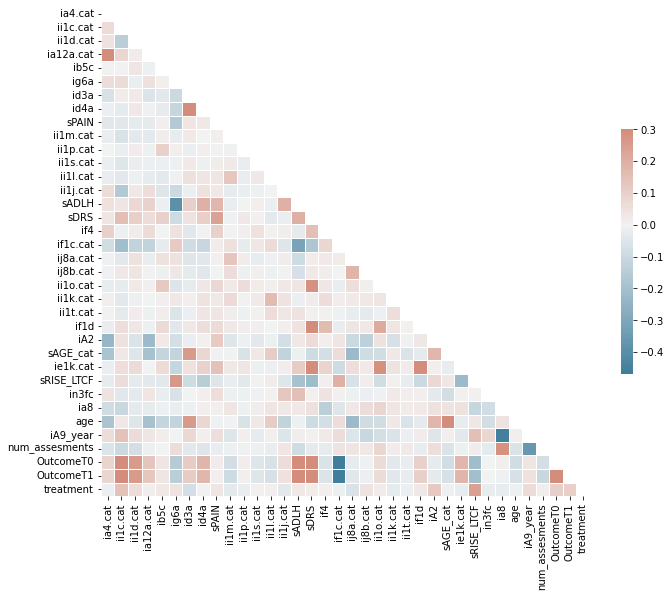

In [137]:
if REMOVE_MULTI_COL:
    print('2sr')
    df = multicol(df, CORRELATION_THRESHOLD)

In [138]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 4793


### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [139]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

In [140]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 4793


### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [141]:
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

In [142]:
# treatment = TREATMENT#'in3eb' # (minutes or days of physical therapy)
# target = #'sADLSF' 

#df = df.drop(columns = 'num_assesments')
df.to_csv(f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [143]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)
            
            

In [144]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(covar)
        except:
            covar_names.append(covar)

In [145]:
covar_names

['ia4.cat',
 'ii1c.cat',
 'ii1d.cat',
 'ia12a.cat',
 'ib5c',
 'ig6a',
 'id3a',
 'id4a',
 'sPAIN',
 'ii1m.cat',
 'ii1p.cat',
 'ii1s.cat',
 'ii1l.cat',
 'ii1j.cat',
 'sADLH',
 'sDRS',
 'if4',
 'if1c.cat',
 'ij8a.cat',
 'ij8b.cat',
 'ii1o.cat',
 'ii1k.cat',
 'ii1t.cat',
 'if1d',
 'iA2',
 'sAGE_cat',
 'ie1k.cat',
 'sRISE_LTCF',
 'in3fc',
 'ia8',
 'age',
 'iA9_year',
 'OutcomeT0']

In [146]:
number_of_rows = len(df)
print("Number of rows:", number_of_rows)

Number of rows: 4793


### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestRegressor()``.

In [147]:
model0 = RandomForestRegressor()
model1 = RandomForestRegressor()

In [148]:
model = model0

In [149]:
# File path for the Excel file
excel_file = f'data/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [150]:
# call your data file here
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

In [151]:
#read the file
df = pd.read_csv(FILE)
ctrl_df = df[df['treatment']==0]
trt_df = df[df['treatment']==1]

In [152]:
len(df)

4793

In [153]:
len(ctrl_df)

1871

In [154]:
ctrl_percentage = len(ctrl_df)/len(df)*100
percentage_rounded=round(ctrl_percentage, 3)
print(percentage_rounded)

39.036


In [155]:
len(trt_df) 

2922

In [156]:
trt_percentage = len(trt_df)/len(df)*100
percentage_rounded=round(trt_percentage, 3)
print(percentage_rounded)

60.964


In [157]:
# a=(pd.crosstab(df['if1d'], margins=True))
# b=(pd.crosstab(df['if1d'],normalize='columns',margins=True).round(3)*100)
# print(pd.concat([a,b],axis=1))

In [158]:
# pip install ace_tools

In [159]:
#Treatment group

In [160]:
#Mean and standarad deviation of all confounders in control group 

In [161]:
mean = ctrl_df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].mean()
std_dev = ctrl_df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].std()
mean_df=pd.DataFrame(mean).reset_index().round(2)
print(mean_df)

std_df=pd.DataFrame(std_dev).reset_index().round(2)
print(std_df)

         index      0
0     sAGE_cat  81.82
1         if1d   0.18
2        in3fc   0.09
3     ij8a.cat   0.13
4     ij8b.cat   0.08
5         id3a   0.73
6         id4a   0.54
7         ig6a   1.55
8         sDRS   2.24
9        sPAIN   0.56
10  sRISE_LTCF   3.52
11       sADLH   2.01
         index     0
0     sAGE_cat  7.85
1         if1d  0.38
2        in3fc  0.42
3     ij8a.cat  0.34
4     ij8b.cat  0.28
5         id3a  0.97
6         id4a  0.82
7         ig6a  1.13
8         sDRS  2.85
9        sPAIN  0.85
10  sRISE_LTCF  2.05
11       sADLH  1.70


In [162]:
#Mean and standarad deviation of all confounders in treatment group 

In [163]:
mean = trt_df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].mean()
std_dev = trt_df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].std()
mean_df=pd.DataFrame(mean).reset_index().round(2)
print(mean_df)

std_df=pd.DataFrame(std_dev).reset_index().round(2)
print(std_df)

         index      0
0     sAGE_cat  81.64
1         if1d   0.20
2        in3fc   0.07
3     ij8a.cat   0.09
4     ij8b.cat   0.11
5         id3a   0.59
6         id4a   0.54
7         ig6a   1.64
8         sDRS   2.35
9        sPAIN   0.62
10  sRISE_LTCF   4.48
11       sADLH   2.10
         index     0
0     sAGE_cat  7.51
1         if1d  0.40
2        in3fc  0.33
3     ij8a.cat  0.29
4     ij8b.cat  0.31
5         id3a  0.85
6         id4a  0.83
7         ig6a  1.09
8         sDRS  2.78
9        sPAIN  0.88
10  sRISE_LTCF  1.82
11       sADLH  1.67


In [164]:
#Mean and standarad deviation of all confounders inall dataset

In [165]:
mean = df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].mean()
std_dev = df[['sAGE_cat', 'if1d', 'in3fc', 'ij8a.cat', 'ij8b.cat','id3a', 'id4a','ig6a','sDRS', 'sPAIN', 'sRISE_LTCF','sADLH']].std()
mean_df=pd.DataFrame(mean).reset_index().round(2)
print(mean_df)

std_df=pd.DataFrame(std_dev).reset_index().round(2)
print(std_df)

         index      0
0     sAGE_cat  81.71
1         if1d   0.19
2        in3fc   0.08
3     ij8a.cat   0.11
4     ij8b.cat   0.10
5         id3a   0.65
6         id4a   0.54
7         ig6a   1.61
8         sDRS   2.31
9        sPAIN   0.60
10  sRISE_LTCF   4.10
11       sADLH   2.07
         index     0
0     sAGE_cat  7.65
1         if1d  0.39
2        in3fc  0.37
3     ij8a.cat  0.31
4     ij8b.cat  0.30
5         id3a  0.90
6         id4a  0.83
7         ig6a  1.11
8         sDRS  2.81
9        sPAIN  0.87
10  sRISE_LTCF  1.97
11       sADLH  1.68


In [166]:
#count and percentage of all confounders in control and treatmnet dataset

In [167]:
trt_counts = trt_df['ia4.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ia4.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ia4.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ia4.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'Married', 0: 'Not Married'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'Married', 0: 'Not Married'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                             count  Percentage
Treatment Group Not Married   2184       74.74
                Married        738       25.26
Control Group   Not Married   1377       73.60
                Married        494       26.40


In [168]:
trt_counts = trt_df['ii1c.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1c.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1c.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1c.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    1778       60.85
                yes   1144       39.15
Control Group   No    1390       74.29
                yes    481       25.71


In [169]:
trt_counts = trt_df['ii1c.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1c.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1c.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1c.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

print(trt_counts)
print(trt_percentages_rounded)

print(ctrl_counts)
print(ctrl_percentages_rounded)

0.0    1778
1.0    1144
Name: ii1c.cat, dtype: int64
0.0    60.85
1.0    39.15
Name: ii1c.cat, dtype: float64
0.0    1390
1.0     481
Name: ii1c.cat, dtype: int64
0.0    74.29
1.0    25.71
Name: ii1c.cat, dtype: float64


In [170]:
trt_counts = trt_df['ii1d.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1d.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1d.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1d.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2185       74.78
                yes    737       25.22
Control Group   No    1497       80.01
                yes    374       19.99


In [171]:
trt_counts = trt_df['ii1m.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1m.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1m.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1m.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2598       88.91
                yes    324       11.09
Control Group   No    1621       86.64
                yes    250       13.36


In [172]:
trt_counts = trt_df['ii1p.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1p.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1p.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1p.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2902       99.32
                yes     20        0.68
Control Group   No    1851       98.93
                yes     20        1.07


In [173]:
trt_counts = trt_df['ii1s.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1s.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1s.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1s.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2676       91.58
                yes    246        8.42
Control Group   No    1717       91.77
                yes    154        8.23


In [174]:
trt_counts = trt_df['ii1l.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1l.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1l.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1l.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2212       75.70
                yes    710       24.30
Control Group   No    1432       76.54
                yes    439       23.46


In [175]:
trt_counts = trt_df['ii1j.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1j.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1j.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1j.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2398       82.07
                yes    524       17.93
Control Group   No    1478       79.00
                yes    393       21.00


In [176]:
trt_counts = trt_df['ii1o.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1o.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1o.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1o.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2446       83.71
                yes    476       16.29
Control Group   No    1589       84.93
                yes    282       15.07


In [177]:
trt_counts = trt_df['ii1k.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1k.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1k.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1k.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2723       93.19
                yes    199        6.81
Control Group   No    1715       91.66
                yes    156        8.34


In [178]:
trt_counts = trt_df['ii1t.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ii1t.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ii1t.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ii1t.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2328       79.67
                yes    594       20.33
Control Group   No    1469       78.51
                yes    402       21.49


In [179]:
trt_counts = trt_df['ie1k.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ie1k.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ie1k.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ie1k.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2323       79.50
                yes    599       20.50
Control Group   No    1449       77.45
                yes    422       22.55


In [180]:
trt_counts = trt_df['if1c.cat'].value_counts(normalize=False)
trt_percentages = trt_df['if1c.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['if1c.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['if1c.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group yes   1997       68.34
                No     925       31.66
Control Group   yes   1304       69.70
                No     567       30.30


In [181]:
trt_counts = trt_df['ia12a.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ia12a.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ia12a.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ia12a.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'alone', 0: 'with partner'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'alone', 0: 'with partner'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                              count  Percentage
Treatment Group with partner   1927       65.95
                alone           995       34.05
Control Group   with partner   1260       67.34
                alone           611       32.66


In [182]:
trt_counts = trt_df['ib5c'].value_counts(normalize=False)
trt_percentages = trt_df['ib5c'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ib5c'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ib5c'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2833       96.95
                yes     89        3.05
Control Group   No    1830       97.81
                yes     41        2.19


In [183]:
trt_counts = trt_df['iA2'].value_counts(normalize=False)
trt_percentages = trt_df['iA2'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['iA2'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['iA2'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'Male', 2: 'Female'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'Male', 2: 'Female'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                        count  Percentage
Treatment Group Female   2180       74.61
                Male      742       25.39
Control Group   Female   1184       63.28
                Male      687       36.72


In [184]:
# count and percentage of confounders in whole dataset

In [185]:
df_counts = df['ia4.cat'].value_counts(normalize=False)
df_percentages = df['ia4.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'Married', 0: 'Not Married'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

             count  Percentage
Not Married   3561        74.3
Married       1232        25.7


In [186]:
df_counts = df['iA2'].value_counts(normalize=False)
df_percentages = df['iA2'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'Male', 2: 'Female'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

        count  Percentage
Female   3364       70.19
Male     1429       29.81


In [187]:
df_counts = df['ii1c.cat'].value_counts(normalize=False)
df_percentages = df['ii1c.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3168        66.1
yes   1625        33.9


In [188]:
df_counts = df['ii1d.cat'].value_counts(normalize=False)
df_percentages = df['ii1d.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3682       76.82
yes   1111       23.18


In [189]:
df_counts = df['ii1m.cat'].value_counts(normalize=False)
df_percentages = df['ii1m.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4219       88.02
yes    574       11.98


In [190]:
df_counts = df['ii1p.cat'].value_counts(normalize=False)
df_percentages = df['ii1p.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4753       99.17
yes     40        0.83


In [191]:
df_counts = df['ii1s.cat'].value_counts(normalize=False)
df_percentages = df['ii1s.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4393       91.65
yes    400        8.35


In [192]:
df_counts = df['ii1l.cat'].value_counts(normalize=False)
df_percentages = df['ii1l.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3644       76.03
yes   1149       23.97


In [193]:
df_counts = df['ii1j.cat'].value_counts(normalize=False)
df_percentages = df['ii1j.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3876       80.87
yes    917       19.13


In [194]:
df_counts = df['ii1o.cat'].value_counts(normalize=False)
df_percentages = df['ii1o.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4035       84.19
yes    758       15.81


In [195]:
df_counts = df['ii1k.cat'].value_counts(normalize=False)
df_percentages = df['ii1k.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4438       92.59
yes    355        7.41


In [196]:
df_counts = df['ii1t.cat'].value_counts(normalize=False)
df_percentages = df['ii1t.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3797       79.22
yes    996       20.78


In [197]:
df_counts = df['ie1k.cat'].value_counts(normalize=False)
df_percentages = df['ie1k.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3772        78.7
yes   1021        21.3


In [198]:
df_counts = df['ia12a.cat'].value_counts(normalize=False)
df_percentages = df['ia12a.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3187       66.49
yes   1606       33.51


In [199]:
df_counts = df['ib5c'].value_counts(normalize=False)
df_percentages = df['ib5c'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4663       97.29
yes    130        2.71


In [200]:
df_counts = df['if4'].value_counts(normalize=False)
df_percentages = df['if4'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    3662        76.4
yes   1131        23.6


In [201]:
df_counts = df['if1c.cat'].value_counts(normalize=False)
df_percentages = df['if1c.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
yes   3301       68.87
No    1492       31.13


In [202]:
df_counts = df['ij8a.cat'].value_counts(normalize=False)
df_percentages = df['ij8a.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4288       89.46
yes    505       10.54


In [203]:
df_counts = df['ij8b.cat'].value_counts(normalize=False)
df_percentages = df['ij8b.cat'].value_counts(normalize=True)*100
df_percentages_rounded=df_percentages.round(2)


#combine into a table 
summary = pd.DataFrame({'count':df_counts, 'Percentage': df_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

# summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

     count  Percentage
No    4318       90.09
yes    475        9.91


In [204]:
trt_counts = trt_df['ij8a.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ij8a.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ij8a.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ij8a.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2660       91.03
                yes    262        8.97
Control Group   No    1628       87.01
                yes    243       12.99


In [205]:
trt_counts = trt_df['ij8b.cat'].value_counts(normalize=False)
trt_percentages = trt_df['ij8b.cat'].value_counts(normalize=True)*100
trt_percentages_rounded=trt_percentages.round(2)

ctrl_counts = ctrl_df['ij8b.cat'].value_counts(normalize=False)
ctrl_percentages = ctrl_df['ij8b.cat'].value_counts(normalize=True)*100
ctrl_percentages_rounded=ctrl_percentages.round(2)

#combine into a table 
trt_summary = pd.DataFrame({'count':trt_counts, 'Percentage': trt_percentages_rounded}).rename(index={1:'yes', 0: 'No'})
ctrl_summary = pd.DataFrame({'count':ctrl_counts, 'Percentage': ctrl_percentages_rounded}).rename(index={1:'yes', 0: 'No'})

summary = pd.concat([trt_summary,ctrl_summary], keys= ['Treatment Group', 'Control Group'])

# import ace_tools as tools; tools.display_dataframe_to_user(name= 'Marital status summary', dataframe=final_summary)
print(summary)

                     count  Percentage
Treatment Group No    2605       89.15
                yes    317       10.85
Control Group   No    1713       91.56
                yes    158        8.44


In [206]:
#df.to_excel("data_2022.xlsx")

In [207]:
#df.loc[(df['iA2'] > 65)]

In [208]:
#all_data_control[all_data_control['iA2']==1] # control group men

In [209]:
#all_data.loc[(all_data['iA2'] == '1') | (all_data['iA2'] == '2')]

Afterwards, we can run the model. The only thing to do is to run the ``run_model``-function below. 

In [210]:
machine = "RandomForest"

metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t = run_model(n_bootstraps = 1, file = FILE, model0 = model0, model1 = model1, undersampled = UNDERSAMPLE, include_propensity = PROPENSITY, intervention = TREATMENT, outcome = OUTCOME, machine = "RandomForest", num_iter = 1)

DF lenght after undersampling: 4793
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test outcome under treatment 2.1789583333333336.
Test outcome under treatment 2.13546875.
(Test) ATE 0.04348958333333375.
ATE: 0.07, 95% CI: [nan, nan]


We can now examine the performance of the model by calling ``metrics``.

In [211]:
metrics

,RandomForest
MAE_C (test),0.404507
MAE_T (test),0.421402
MSE_C (test),0.389440
MSE_T (test),0.413173
R2_C (test),0.829354
R2_T (test),0.808558
MAE_C (train),0.158656
MAE_T (train),0.168378
MSE_C (train),0.058350
MSE_T (train),0.069688


In [212]:
confidence_interval(data=ites_test)

(0.023047126257238308, 0.06393204040942835)


In [213]:
significance(data=ites_test)

T-statistic: 4.174925263411945
P-value: 3.252049373780458e-05
Result is statistically significant


We can also visualise the model's *factual* predicted performance by calling the ``visualise`` function.

In [214]:
len(y_test_t)

585

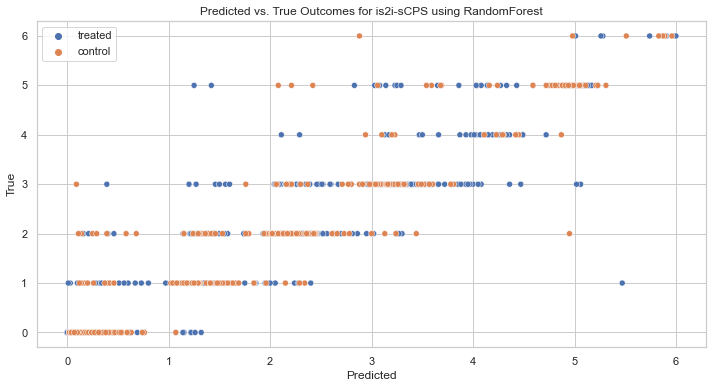

In [215]:
machine = "RandomForest"
visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Also, if we want to visualize the ITES, we can run the following function (``visualise_ites``):

ATE 0.04348958333333333


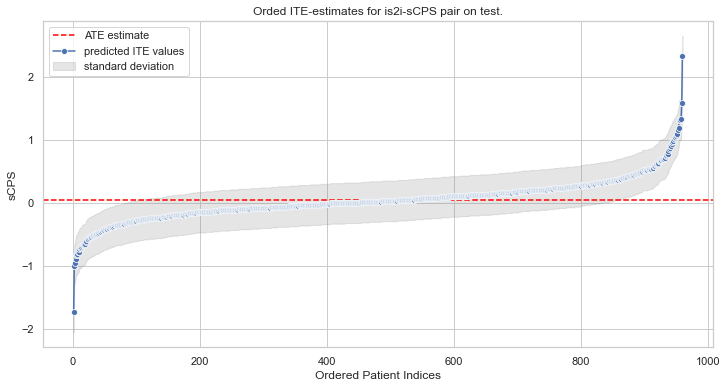

In [216]:
visualise_ites(ites_test, machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE 0.04992955909209496


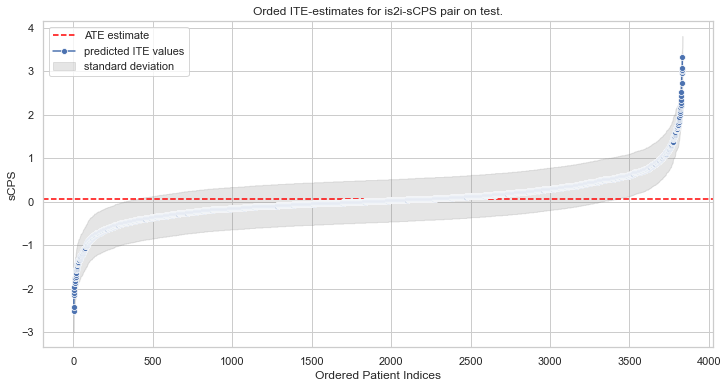

In [217]:
visualise_ites(ites_train, machine = machine, intervention = TREATMENT, target = OUTCOME)

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestRegressor()``
- ``GradientBoostingRegressor()``
- ``LinearRegression()``

RandomForestRegressor()
DF lenght after undersampling: 4793
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test outcome under treatment 2.1789583333333336.
Test outcome under treatment 2.13546875.
(Test) ATE 0.04348958333333375.
ATE: 0.07, 95% CI: [nan, nan]
ATE 0.04348958333333333


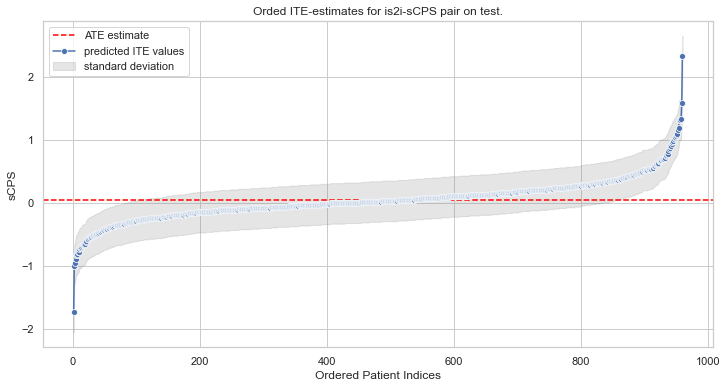

(0.023047126257238308, 0.06393204040942835)
T-statistic: 4.174925263411945
P-value: 3.252049373780458e-05
Result is statistically significant
               RandomForestRegressor()
MAE_C (test)                  0.404507
MAE_T (test)                  0.421402
MSE_C (test)                  0.389440
MSE_T (test)                  0.413173
R2_C (test)                   0.829354
R2_T (test)                   0.808558
MAE_C (train)                 0.158656
MAE_T (train)                 0.168378
MSE_C (train)                 0.058350
MSE_T (train)                 0.069688
R2_C (train)                  0.973425
R2_T (train)                  0.971896
MLPRegressor()
DF lenght after undersampling: 4793
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10,

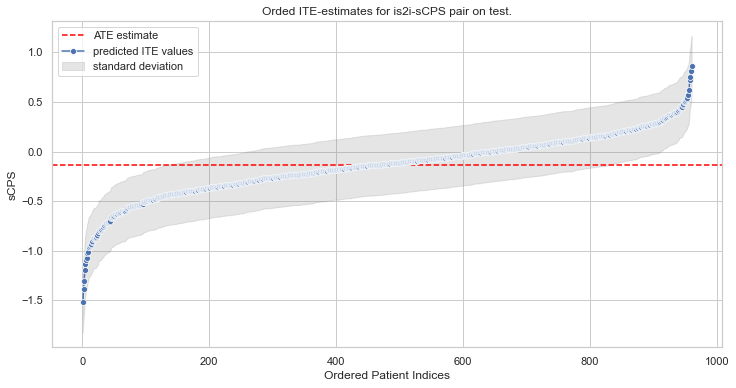

(-0.15940371295655908, -0.12081270500352313)
T-statistic: -14.249643798658818
P-value: 6.221857275330337e-42
Result is statistically significant
               MLPRegressor()
MAE_C (test)         0.404507
MAE_T (test)         0.387416
MSE_C (test)         0.389440
MSE_T (test)         0.378234
R2_C (test)          0.829354
R2_T (test)          0.818403
MAE_C (train)        0.158656
MAE_T (train)        0.418776
MSE_C (train)        0.058350
MSE_T (train)        0.469310
R2_C (train)         0.973425
R2_T (train)         0.793128
GradientBoostingRegressor()
DF lenght after undersampling: 4793
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 't

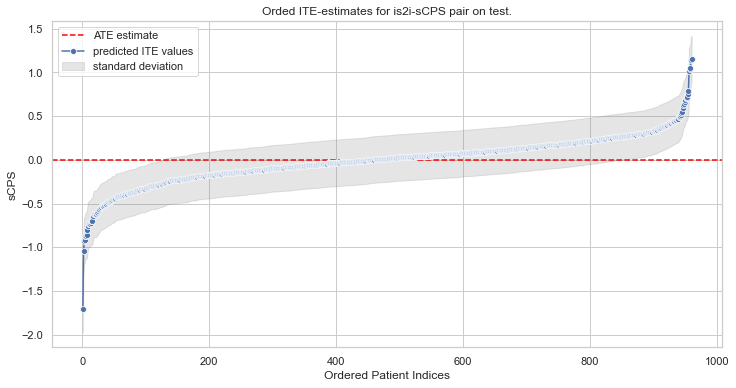

(-0.020073540395351926, 0.013676460058095996)
T-statistic: -0.3719671395617049
P-value: 0.7099994901686641
Result is not significant
               GradientBoostingRegressor()
MAE_C (test)                      0.404507
MAE_T (test)                      0.405432
MSE_C (test)                      0.389440
MSE_T (test)                      0.372314
R2_C (test)                       0.829354
R2_T (test)                       0.825215
MAE_C (train)                     0.158656
MAE_T (train)                     0.381039
MSE_C (train)                     0.058350
MSE_T (train)                     0.341691
R2_C (train)                      0.973425
R2_T (train)                      0.853197
DecisionTreeRegressor()
DF lenght after undersampling: 4793
{'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'rando

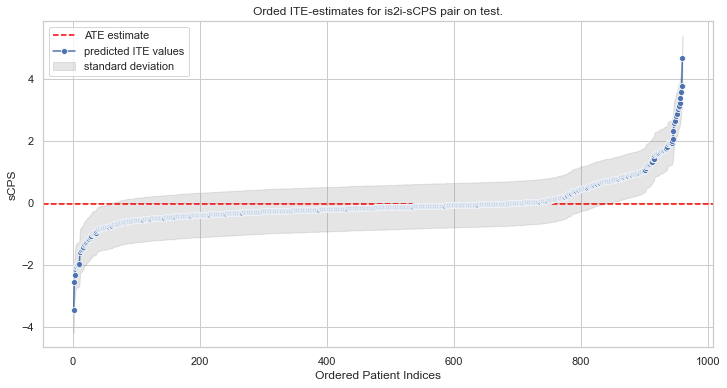

(-0.06627229355979897, 0.02450146022646566)
T-statistic: -0.9030450106620032
P-value: 0.36672877293197204
Result is not significant
               DecisionTreeRegressor()
MAE_C (test)                  0.404507
MAE_T (test)                  0.456410
MSE_C (test)                  0.389440
MSE_T (test)                  0.753846
R2_C (test)                   0.829354
R2_T (test)                   0.696162
MAE_C (train)                 0.158656
MAE_T (train)                 0.000000
MSE_C (train)                 0.058350
MSE_T (train)                 0.000000
R2_C (train)                  0.973425
R2_T (train)                  1.000000
LinearRegression()
DF lenght after undersampling: 4793
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
Test outcome under treatment 2.1267754125618703.
Test outcome under treatment 2.13546875.
(Test) ATE -0.0086933374381295.
ATE: 0.04, 95% CI: [nan, nan]
ATE -0.008693337438129634


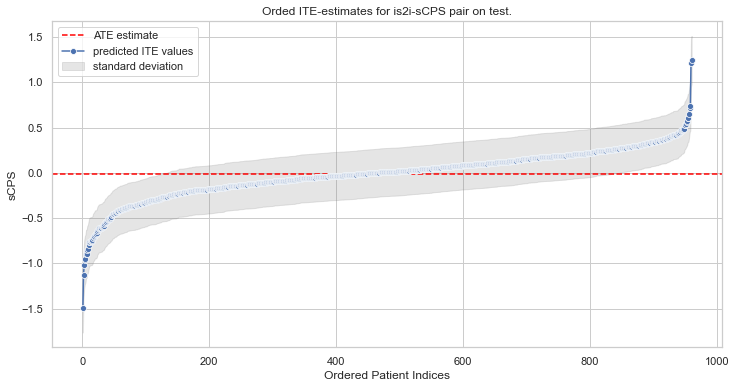

(-0.025517822445848985, 0.008131147569589698)
T-statistic: -1.0140078359684035
P-value: 0.31083477078148675
Result is not significant
               LinearRegression()
MAE_C (test)             0.404507
MAE_T (test)             0.391214
MSE_C (test)             0.389440
MSE_T (test)             0.357873
R2_C (test)              0.829354
R2_T (test)              0.830942
MAE_C (train)            0.158656
MAE_T (train)            0.420307
MSE_C (train)            0.058350
MSE_T (train)            0.440574
R2_C (train)             0.973425
R2_T (train)             0.809429
Ridge()
DF lenght after undersampling: 4793
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Test outcome under treatment 2.1283755793806702.
Test outcome under treatment 2.13546875.
(Test) ATE -0.00709317061932957.
ATE: 0.05, 95% CI: [nan, nan]
ATE -0.007093170619329555


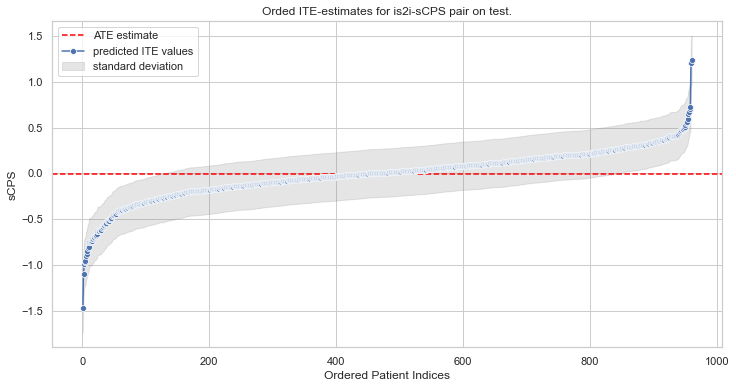

(-0.023807643309906954, 0.00962130207124778)
T-statistic: -0.8328068328049733
P-value: 0.4051610302903117
Result is not significant
                Ridge()
MAE_C (test)   0.404507
MAE_T (test)   0.390670
MSE_C (test)   0.389440
MSE_T (test)   0.358184
R2_C (test)    0.829354
R2_T (test)    0.831094
MAE_C (train)  0.158656
MAE_T (train)  0.420255
MSE_C (train)  0.058350
MSE_T (train)  0.440748
R2_C (train)   0.973425
R2_T (train)   0.809264
Lasso()
DF lenght after undersampling: 4793
{'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Test outcome under treatment 2.189672473688856.
Test outcome under treatment 2.13546875.
(Test) ATE 0.054203723688856176.
ATE: 0.12, 95% CI: [nan, nan]
ATE 0.054203723688855995


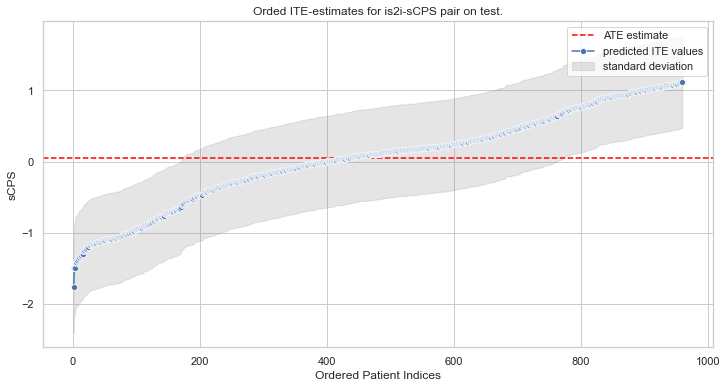

(0.013400968941093695, 0.09500647843661836)
T-statistic: 2.606970945360481
P-value: 0.00927651594733967
Result is statistically significant
                Lasso()
MAE_C (test)   0.404507
MAE_T (test)   0.664259
MSE_C (test)   0.389440
MSE_T (test)   0.696889
R2_C (test)    0.829354
R2_T (test)    0.030759
MAE_C (train)  0.158656
MAE_T (train)  0.731944
MSE_C (train)  0.058350
MSE_T (train)  0.861973
R2_C (train)   0.973425
R2_T (train)  -0.104197
AdaBoostRegressor()
DF lenght after undersampling: 4793
{'base_estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': None}
Test outcome under treatment 2.602560887346478.
Test outcome under treatment 2.13546875.
(Test) ATE 0.46709213734647825.
ATE: 0.45, 95% CI: [nan, nan]
ATE 0.46709213734647786


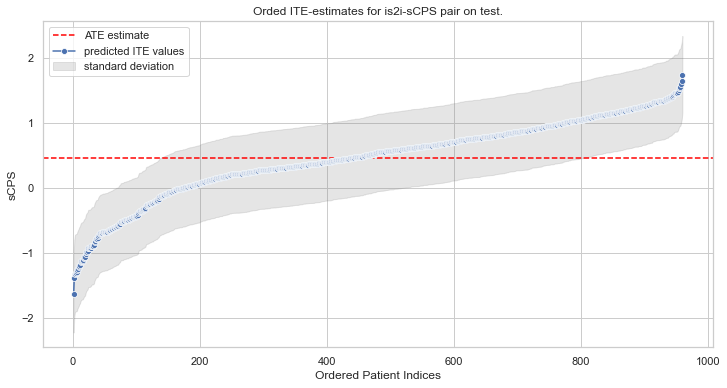

(0.4293738290071756, 0.5048104456857803)
T-statistic: 24.30227346494187
P-value: 4.912509569738595e-102
Result is statistically significant
               AdaBoostRegressor()
MAE_C (test)              0.404507
MAE_T (test)              0.836418
MSE_C (test)              0.389440
MSE_T (test)              0.897544
R2_C (test)               0.829354
R2_T (test)               0.263444
MAE_C (train)             0.158656
MAE_T (train)             0.857975
MSE_C (train)             0.058350
MSE_T (train)             0.926005
R2_C (train)              0.973425
R2_T (train)              0.257229
ExtraTreesRegressor()
DF lenght after undersampling: 4793
{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'rand

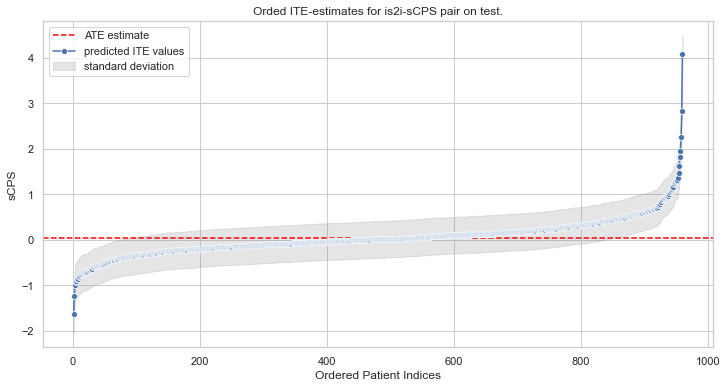

(0.025303061952655796, 0.07650943804734425)
T-statistic: 3.901877344234353
P-value: 0.00010211474614839577
Result is statistically significant
               ExtraTreesRegressor()
MAE_C (test)                0.404507
MAE_T (test)                0.440547
MSE_C (test)                0.389440
MSE_T (test)                0.464584
R2_C (test)                 0.829354
R2_T (test)                 0.792779
MAE_C (train)               0.158656
MAE_T (train)               0.000000
MSE_C (train)               0.058350
MSE_T (train)               0.000000
R2_C (train)                0.973425
R2_T (train)                1.000000
BaggingRegressor()
DF lenght after undersampling: 4793
{'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test outcome under treatment 2.168854166666667.
Test outcome under treatment 2.13546875.
(Test

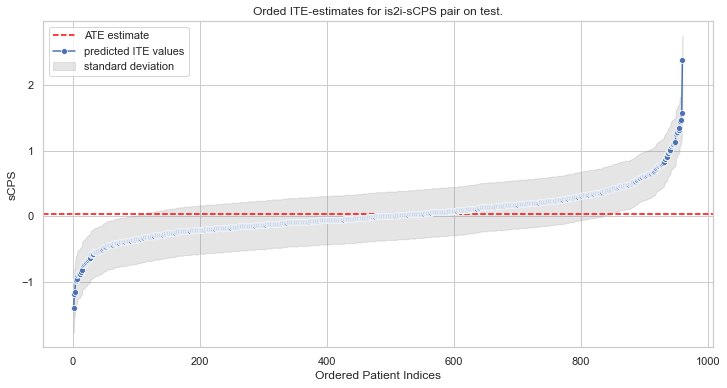

(0.010044603293115562, 0.056726230040217804)
T-statistic: 2.8069673940939364
P-value: 0.005102385472391517
Result is statistically significant
               BaggingRegressor()
MAE_C (test)             0.404507
MAE_T (test)             0.426838
MSE_C (test)             0.389440
MSE_T (test)             0.444940
R2_C (test)              0.829354
R2_T (test)              0.799455
MAE_C (train)            0.158656
MAE_T (train)            0.179033
MSE_C (train)            0.058350
MSE_T (train)            0.101463
R2_C (train)             0.973425
R2_T (train)             0.959641


In [218]:
model_lst = [(RandomForestRegressor(),RandomForestRegressor()), (MLPRegressor(), MLPRegressor()), 
            (GradientBoostingRegressor(), GradientBoostingRegressor()), (DecisionTreeRegressor(), DecisionTreeRegressor()),
            (LinearRegression(), LinearRegression()), (Ridge(), Ridge()), (Lasso(), Lasso()),
            (AdaBoostRegressor(), AdaBoostRegressor()), (ExtraTreesRegressor(), ExtraTreesRegressor()), 
             (BaggingRegressor(), BaggingRegressor())]

for model1, model2 in model_lst:
    np.random.seed(42)
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t = run_model(n_bootstraps = 1, file = FILE, include_propensity = PROPENSITY, outcome=OUTCOME, intervention=TREATMENT, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    confidence_interval(data=ites_test)
    significance(data=ites_test)
    print(metrics)

In [219]:
X_train_t

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,iA2,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,age,iA9_year,OutcomeT0,ps
3010,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,85.0,0.0,6.0,0.0,1.0,85.0,2020.0,1.0,0.670322
4478,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.0,70.0,0.0,2.0,0.0,1.0,70.0,2019.0,3.0,0.646900
4155,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,2.0,90.0,0.0,4.0,0.0,1.0,90.0,2020.0,1.0,0.592539
4590,0.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,...,2.0,85.0,0.0,5.0,0.0,1.0,85.0,2020.0,2.0,0.830938
3981,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,2.0,90.0,0.0,6.0,0.0,1.0,90.0,2020.0,2.0,0.758564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2954,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,90.0,1.0,3.0,0.0,2.0,90.0,2022.0,5.0,0.540704
1860,1.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,...,1.0,80.0,0.0,5.0,0.0,2.0,80.0,2010.0,2.0,0.682537
482,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,...,2.0,85.0,1.0,5.0,0.0,2.0,85.0,2008.0,3.0,0.774121
905,1.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,...,2.0,65.0,0.0,4.0,0.0,2.0,65.0,2008.0,6.0,0.906377


In [220]:
X_train_c

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,iA2,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,age,iA9_year,OutcomeT0,ps
662,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,2.0,95.0,0.0,2.0,0.0,2.0,95.0,2008.0,2.0,0.372510
4087,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,...,1.0,75.0,0.0,6.0,0.0,2.0,75.0,2019.0,1.0,0.506302
2197,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,2.0,95.0,1.0,6.0,0.0,1.0,95.0,2012.0,3.0,0.706038
1736,1.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,1.0,...,1.0,80.0,0.0,6.0,0.0,2.0,80.0,2010.0,1.0,0.623085
4076,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,...,1.0,85.0,0.0,6.0,0.0,2.0,85.0,2021.0,0.0,0.580662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2.0,75.0,1.0,6.0,0.0,1.0,75.0,2016.0,1.0,0.738565
3191,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,...,1.0,80.0,0.0,5.0,0.0,2.0,80.0,2019.0,2.0,0.644157
2007,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,80.0,0.0,3.0,0.0,2.0,80.0,2011.0,3.0,0.560110
3715,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,...,1.0,80.0,1.0,5.0,0.0,2.0,80.0,2018.0,2.0,0.494153


In [221]:
metrics

,BaggingRegressor()
MAE_C (test),0.404507
MAE_T (test),0.426838
MSE_C (test),0.389440
MSE_T (test),0.444940
R2_C (test),0.829354
R2_T (test),0.799455
MAE_C (train),0.158656
MAE_T (train),0.179033
MSE_C (train),0.058350
MSE_T (train),0.101463


In [222]:
#3.c IDs for Evaluation

In [223]:
predictions = pd.DataFrame(pd.concat([y_test_c, y_test_t])).reset_index()
vars_test = pd.concat([X_test_t, X_test_c]).reset_index()

In [224]:
index_df = pd.merge(predictions, vars_test, left_index=True, right_index=True)
index_df["ITEs"] = index_df['OutcomeT1'] - index_df["OutcomeT0"]

index_df.head()

,index_x,OutcomeT1,index_y,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,...,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,age,iA9_year,OutcomeT0,ps,ITEs
0,4409,2.0,2025,0.0,0.0,0.0,0.0,0.0,2.0,1.0,...,90.0,0.0,2.0,0.0,2.0,90.0,2011.0,0.0,0.433806,2.0
1,2867,1.0,962,0.0,1.0,1.0,0.0,0.0,1.0,2.0,...,65.0,0.0,5.0,0.0,2.0,65.0,2009.0,5.0,0.841704,-4.0
2,4791,1.0,3100,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,80.0,0.0,4.0,0.0,2.0,80.0,2020.0,5.0,0.861866,-4.0
3,724,5.0,3934,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,85.0,1.0,2.0,0.0,2.0,85.0,2020.0,1.0,0.386810,4.0
4,1072,4.0,4557,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,70.0,0.0,6.0,0.0,2.0,70.0,2019.0,1.0,0.795740,3.0


## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

In [225]:
device = torch.device("cpu")

It is useful to have a small function that easily converts arrays to the correct ``torch``-objects: tensors.

In [226]:
to_tensor = lambda x: torch.tensor(np.array(x), dtype = torch.float32).to(device)

In [227]:
FILE = f"data/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"
df = pd.read_csv(FILE)

### Uplift Model

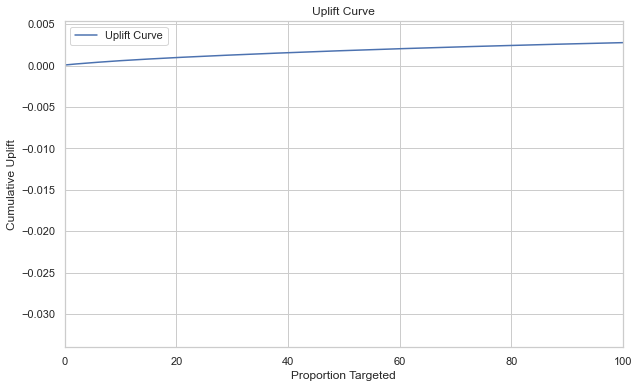

In [228]:
# Split into features and target
X = df.drop('OutcomeT1', axis=1)
y = df['OutcomeT1']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model on treatment group
model_treatment = LogisticRegression()
model_treatment.fit(X_train[X_train['treatment'] == 1].drop('treatment', axis=1), y_train[X_train['treatment'] == 1])

# Train model on control group
model_control = LogisticRegression()
model_control.fit(X_train[X_train['treatment'] == 0].drop('treatment', axis=1), y_train[X_train['treatment'] == 0])

# Predict probabilities
prob_treatment = model_treatment.predict_proba(X_test.drop('treatment', axis=1))[:, 1]
prob_control = model_control.predict_proba(X_test.drop('treatment', axis=1))[:, 1]

# Calculate uplift
uplift = prob_treatment - prob_control

# Sorting the individuals by predicted uplift
order = np.argsort(uplift)[::-1]
sorted_uplift = uplift[order]

# Calculating cumulative uplift
cumulative_uplift = np.cumsum(sorted_uplift) / len(y_test)

# Plotting
plt.figure(figsize=(10, 6))
plt.xlim(0,100)
plt.plot(cumulative_uplift, label='Uplift Curve')
plt.xlabel('Proportion Targeted')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()
plt.show()

In [229]:
# apply min-max normalisation
#X = df.drop(columns = ['treatment', 'OutcomeT1']).columns
#df[X] = (df[X] - df[X].min()) / (df[X].max() - df[X].min())

In [230]:
X = df.drop(columns = ['treatment', 'OutcomeT1']).columns

normalizer = Normalizer(norm="l2")
normalizer.fit(df[X])

df[X] = normalizer.fit_transform(df[X])

with open(f'storage/normalizer_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

### 4 a. Perform Undersampling Procedure

In [231]:
if UNDERSAMPLE:
    freq_treated = len(df[df['treatment']==1])
    control = df[df['treatment']==0].sample(freq_treated)
    treated = df[df['treatment']==1]
    df = pd.concat((control, treated))
    
print(f'DF lenght after undersampling: {len(df)}')

DF lenght after undersampling: 4793


Because the model is a neural-network based architecture, it is usually helpful to apply min-max normalisation which converts the column values to \[0,1\] ranges.

### 4.b Train-Test Splitting

In the cell below, we perform train-test split. Note that we also split the train and test data into two groups: a control group and a treated group. Even though we do not explicItely use for train, it will be useful for the (sub-)group evaluation later on.

In [232]:
# variable setting for treatment
t = 'treatment'
# select the relevant outcome
y = "OutcomeT1" 
# specify test size
test_size = 0.2

# Split groups into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [y]), df[['treatment', y]], test_size=test_size, random_state=42)

### 4.c Propensity Score Computation

In [233]:
# predict the propensity score
if PROPENSITY:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]
    X_test["OutcomeT1"] = y_test["OutcomeT1"]
    X = X_train.drop(columns = ['treatment']).columns
    X = X_test.drop(columns = ['treatment']).columns
    ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(X_train[X], y_train['treatment'])
    X_train['ps'] = ps_model.predict_proba(X_train[X])[:, 1]
    X_test['ps'] = ps_model.predict_proba(X_test[X])[:, 1]
    
    # ensure that treatment is last column
    X_train['treatment_new'] =  X_train['treatment']
    X_train = X_train.drop(columns = ['treatment'])
    X_train = X_train.rename(columns = {'treatment_new': 'treatment'})
    
    X_test['treatment_new'] =  X_test['treatment']
    X_test = X_test.drop(columns = ['treatment'])
    X_test = X_test.rename(columns = {'treatment_new': 'treatment'})
    
    #X_train = X_train.drop(columns = ["OutcomeT1"])
else:
    X_train["OutcomeT1"] = y_train["OutcomeT1"]

In [234]:
X = df.drop(columns = ['OutcomeT1', 'treatment']).columns

#X_train = X_train.drop(columns = ["ps"])

# Estimate the average treatment effect (group level)
tau_est = doubly_robust(X_train, X=X, T='treatment', Y='OutcomeT1')
tau_est = torch.tensor(tau_est, dtype = torch.float32).to(device)
print(tau_est)

# drop columns
X_train = X_train.drop(columns = ["OutcomeT1"])

if PROPENSITY == True:
    X_test = X_test.drop(columns = ["OutcomeT1"])

Estimated outcome under control 2.0930499370417293.
Estimated outcome under treatment 2.1173740620859753.
tensor(0.0243)


In [235]:
X_train

,ia4.cat,ii1c.cat,ii1d.cat,ia12a.cat,ib5c,ig6a,id3a,id4a,sPAIN,ii1m.cat,...,sAGE_cat,ie1k.cat,sRISE_LTCF,in3fc,ia8,age,iA9_year,OutcomeT0,ps,treatment
2649,0.000000,0.000000,0.000495,0.000000,0.0,0.001486,0.000495,0.000000,0.000000,0.000495,...,0.034663,0.000000,0.002971,0.0,0.000990,0.034663,0.998790,0.000990,0.619501,1.0
1451,0.000000,0.000000,0.000000,0.000000,0.0,0.000497,0.000000,0.000000,0.000000,0.000000,...,0.042213,0.000497,0.001490,0.0,0.000993,0.042213,0.998213,0.000993,0.603855,1.0
3329,0.000000,0.000000,0.000000,0.000000,0.0,0.000990,0.000000,0.000000,0.000000,0.000000,...,0.039581,0.000000,0.002969,0.0,0.000495,0.039581,0.998426,0.000000,0.554545,1.0
1691,0.000000,0.000000,0.000497,0.000000,0.0,0.000497,0.000000,0.001490,0.000000,0.000000,...,0.039738,0.000000,0.000497,0.0,0.000497,0.039738,0.998415,0.000993,0.593556,1.0
4305,0.000000,0.000000,0.000000,0.000000,0.0,0.001483,0.000494,0.000000,0.000000,0.000000,...,0.044488,0.000000,0.001977,0.0,0.000494,0.044488,0.998015,0.000000,0.577115,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,0.000000,0.000000,0.000000,0.000000,0.0,0.000494,0.000494,0.000000,0.000000,0.000000,...,0.046903,0.000000,0.000987,0.0,0.000494,0.046903,0.997794,0.000494,0.598298,1.0
466,0.000000,0.000000,0.000000,0.000497,0.0,0.000994,0.000497,0.000000,0.000497,0.000000,...,0.039777,0.000000,0.002486,0.0,0.000994,0.039777,0.998408,0.000000,0.547141,0.0
3092,0.000000,0.000000,0.000000,0.000000,0.0,0.000495,0.000000,0.000000,0.000495,0.000000,...,0.037114,0.000000,0.002969,0.0,0.000990,0.037114,0.998614,0.000495,0.586189,1.0
3772,0.000494,0.000494,0.000000,0.000494,0.0,0.001483,0.000000,0.000494,0.000000,0.000000,...,0.034612,0.000494,0.002472,0.0,0.000494,0.034612,0.998794,0.000989,0.613974,1.0


We also want to make sure that the data stuctures are in the right format. For this, we use ``to_tensor``.

In [236]:
y_t = y_train[y_train['treatment']==1][y]
y_c = y_train[y_train['treatment']==0][y]

y_test_t = y_test[y_test['treatment']==1][y]
y_test_c = y_test[y_test['treatment']==0][y]

In [237]:
# convert output to tensors
x, y, y_t, y_c, x_test = to_tensor(X_train), to_tensor(y_train), to_tensor(y_t), to_tensor(y_c), to_tensor(X_test)

### 4.d Model Training

The next step is to train the actual model. The code below sets some preliminary configurations.

In [238]:
# Configurations
lr = 0.001
epochs = 1000
gamma = 2

model = TARnetICFR(x.shape[1], 0.01, hidden_dim = 32*4).to(device)

# Define the loss functions
head_loss = nn.L1Loss() #nn.MSELoss()#nn.L1Loss() #torch.nn.HuberLoss(reduction = 'mean', delta = 1) #nn.MSELoss() # nn.L1Loss() #nn.MSELoss() 

# initialise optimiser
optimizer = optim.Adam(model.parameters(), lr)

u = len(y_t)  / (len(y_t)  + len(y_c))

The code below is the training loop. On each loop, the model passes the data through the models, examines its performance and adjust the weights. Note that this model has four loss components:

1. Component 1 (``loss1``) is to loss on the treated segment of the data.
2. Component 2 (``loss2``) is to loss on the control segment of the data.
3. Component 2 (``loss_cf_3``) is to loss on the counterfactual control segment of the data.
4. Component 2 (``loss_cf_4``) is to loss on the counterfactual treated segment of the data.

In [239]:
# Define loss lists
loss1_lst, loss2_lst, loss3_lst = [], [], []

for epoch in range(epochs):
    # Forward pass
    output_t, output_c, _ = model(x)
    
    # Compute total loss and update the model's parameters
    loss1, loss2 = head_loss(torch.squeeze(output_t), y_t), head_loss(torch.squeeze(output_c), y_c)
    
    pred_c_cf = model.forward_treated(x[x[:,-1]==0])
    loss_cf_3 = (1 - u) * torch.mean((torch.squeeze(pred_c_cf) - (y_c + tau_est))**2)
                 
    pred_t_cf = model.forward_control(x[x[:,-1]==1])
    loss_cf_4 = u * torch.mean((torch.squeeze(pred_t_cf) - (y_t - tau_est))**2)
    
    # losses added
    loss = loss1 + (loss2) + loss_cf_3 + loss_cf_4 #+ (gamma * loss3)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print the loss every 10000 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}')
        
        # print intermediate results on test
        x_test_t = x_test[x_test[:,-1]==1] 
        x_test_c = x_test[x_test[:,-1]==0] 

        # # examine intermediate factual test performance
        y_t_pred = model.forward_treated(x_test_t).cpu().detach().numpy().reshape(len(x_test_t),)
        y_c_pred = model.forward_control(x_test_c).cpu().detach().numpy().reshape(len(x_test_c),)

        print(f"RMSE for factual treated {mean_squared_error(y_t_pred, y_test_t)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_t_pred, y_test_t)}") 
        print(f"RMSE for factual control {mean_squared_error(y_c_pred, y_test_c)}") 
        print(f"MAE for factual treated {mean_absolute_error(y_c_pred, y_test_c)}") 

Epoch 100/1000 | Loss: 1.0388
RMSE for factual treated 0.2209962179239996
MAE for factual treated 0.386816178367934
RMSE for factual control 0.2338025510558853
MAE for factual treated 0.39036909282559484
Epoch 200/1000 | Loss: 0.5869
RMSE for factual treated 0.10431247476236685
MAE for factual treated 0.24871465072654522
RMSE for factual control 0.10299759219092802
MAE for factual treated 0.268180375801414
Epoch 300/1000 | Loss: 0.5287
RMSE for factual treated 0.09387922095866597
MAE for factual treated 0.23531946154459538
RMSE for factual control 0.08185959307517053
MAE for factual treated 0.2323994276130919
Epoch 400/1000 | Loss: 0.5359
RMSE for factual treated 0.10542842592621321
MAE for factual treated 0.24581952846792743
RMSE for factual control 0.0683760125922232
MAE for factual treated 0.20785912442121293
Epoch 500/1000 | Loss: 0.4371
RMSE for factual treated 0.08690839723905885
MAE for factual treated 0.21847105384594842
RMSE for factual control 0.0639461065810342
MAE for factu

### 4.e Model Evaluation
Having trained the model, we can no examine the performance on the test set. We first get the predictions for the treated and control groups. Then we visualise the predicted predicted vs. true values. 

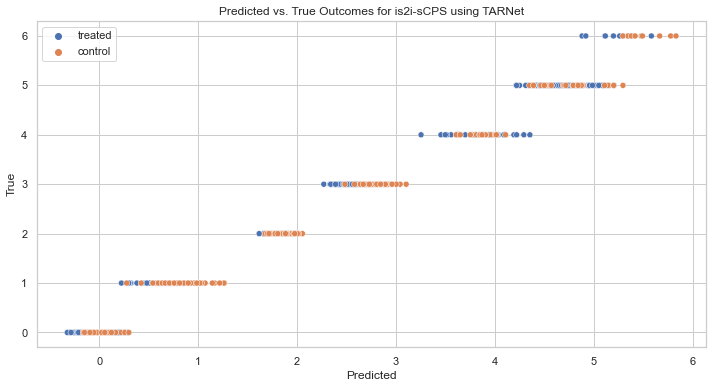

In [240]:
y_t_pred = model.forward_treated(x_test[x_test[:,-1]==1] ).cpu().detach().numpy()
y_c_pred = model.forward_control(x_test[x_test[:,-1]==0] ).cpu().detach().numpy()

machine = "TARNet"
visualise(np.squeeze(y_t_pred), np.squeeze(y_c_pred), y_test_t, y_test_c, machine=machine, target=OUTCOME, intervention=TREATMENT)

Next, we want to estimate the model's predictions of the individual treatment effect. We plot this in an ordered fashion (from most beneficial to least beneficial). The blue dots depict patients. On the y-axis, we find the effect size as predicted by the model. 

ATE_est = 1.9930732250213623 - 1.979222297668457 = 0.013850988820195198.
ATE 0.01385098323225975


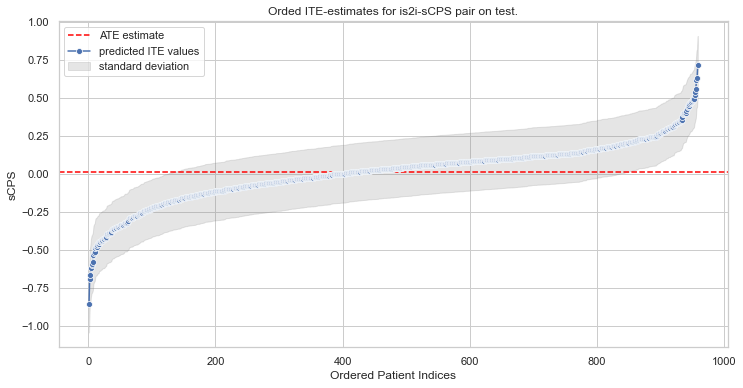

In [241]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()
y_t_predt1 = model.forward_treated(x_test_t).cpu().detach().numpy()
y_t_pred = np.concatenate((y_c_predt1, y_t_predt1))

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() #np.array(y_test_c).reshape(-1,1) #model.forward_control(x_test_c).cpu().detach().numpy()
y_t_predt0 = model.forward_control(x_test_t).cpu().detach().numpy()

y_c_pred = np.concatenate((y_c_predt0, y_t_predt0))

# compute the ites and sort
ites = y_t_pred - y_c_pred
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_t_pred - y_c_pred)

print(f"ATE_est = {np.mean(y_t_pred)} - {np.mean(y_c_pred)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

ATE_est = 1.813149094581604 - 1.8032891750335693 = 0.009860124439001083.
ATE 0.009860126301646233


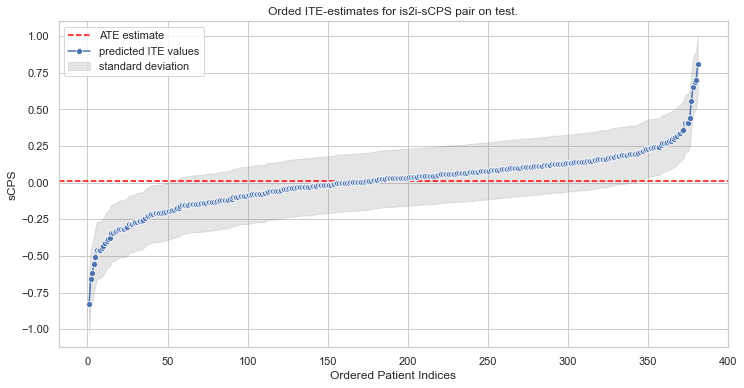

In [242]:
# isolate and disconnect predicted values
y_c_predt1 = model.forward_treated(x_test_c).cpu().detach().numpy()

# isolate and disconnect predicted values
y_c_predt0 = model.forward_control(x_test_c).cpu().detach().numpy() 

# compute the ites and sort
ites = y_c_predt1 - y_c_predt0
ites = [i[0] for i in ites]
ites = sorted(list(ites))

ate_model_est = np.mean(y_c_predt1 - y_c_predt0)

print(f"ATE_est = {np.mean(y_c_predt1)} - {np.mean(y_c_predt0)} = {ate_model_est}.")

visualise_ites(np.array(ites), machine = machine, intervention = TREATMENT, target = OUTCOME)

### 4.e Variable Importances

In [243]:
np.random.seed(42)

# Calculate the baseline performance
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Ensure no gradients are computed
    output_t, output_c, _ = model(x)
baseline_performance = mean_squared_error(output_t, y_t)
print(baseline_performance)

# Initialize a list to hold the feature importances
feature_importances = []
icodes = []
meanings = []
rank = []

collist = X_train.columns

# Calculate the importance for each feature
for i in range(x.shape[1]):  # Iterate over each feature
    # Save the original feature
    original_feature = x[:, i].clone()
    # Permute the feature
    permuted_feature = original_feature[torch.randperm(original_feature.size(0))]
    x[:, i] = permuted_feature
    
    # Calculate performance with the permuted data
    with torch.no_grad():
        output_t, output_c, _ = model(x)
        
    permuted_performance_t = mean_squared_error(output_t, y_t)
    permuted_performance_c = mean_squared_error(output_c, y_c)
    
    permuted_performance = permuted_performance_t + permuted_performance_t
    
    # Calculate the importance as the change in performance
    importance = baseline_performance - permuted_performance
    feature_importances.append(importance)
    
    # Restore the original feature
    x[:, i] = original_feature
    
# Rank the features by their importance
sorted_features = np.argsort(feature_importances)[::-1]  # Indices of features, sorted by importance

# Print the feature importances
print("Feature importances:")
for i, feature_index in enumerate(sorted_features):
    #print(f"Feature {feature_index}: Importance {feature_importances[feature_index]}")
    icode = collist[feature_index]
    icodes.append(icode.lower())
    
    try:
        item = encoding[icode.lower()]
        #print(item)
        meanings.append(item)
    except KeyError:
        #print(f'{icode} not found')
        meanings.append(f'{icode} not found')
    #print("==================================================")
    
rankings = pd.DataFrame(icodes, columns = ['icodes'])
rankings['meanings'] = meanings
rankings['importance_values'] = feature_importances

rankings = rankings.sort_values(by = 'importance_values')
rankings = rankings.reset_index().drop(columns = 'index')
rankings

0.06955108
Feature importances:


,icodes,meanings,importance_values
0,treatment,treatment not found,-10.030101
1,ps,ps not found,-8.831278
2,age,age not found,-0.218727
3,srise_ltcf,sRISE_LTCF not found,-0.092848
4,sage_cat,sAGE_cat not found,-0.077393
5,if1d,Loneliness: indicates feelings of loneliness,-0.075738
6,in3fc,in3fc not found,-0.074382
7,sdrs,sDRS depression rating scale (0-14),-0.072251
8,spain,sPAIN not found,-0.071316
9,ia2,Gender,-0.070842


## Save Model

In [244]:
model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,

In [245]:
model = model
location = 'storage'

In [246]:
# save model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'wb') as f:
    pickle.dump(model, f)

In [247]:
# load model
with open(f'storage/model_{TREATMENT}-{OUTCOME}.pkl', 'rb') as b:
    loaded_model = pickle.load(b)

In [248]:
loaded_model

TARnetICFR(
  (phi): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=128, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ELU(alpha=1.0)
  )
  (y0_hidden): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (y1_hidden): Sequential(
    (0): Linear(in_features=128,